# Eat Black and White Beans

There are white and black beans (with equal amount) in a container.
For each time, randomly select one bean from the container. If it's black, eat it immediately.
Otherwise, put it back and select again, and eat it regardless of its color.
Repeat the above operation until container empty.
Find the probability that last bean eaten is black.


# Analyze

It is clear that black beans are more probable to be eaten, therefore white beans tends to
be left more than black beans. The probability to be found should be less than 1/2.
Lets say there are $n$ white beans and $n$ black beans.
When $n=1$, we can easily calculate the probability:
$$
P(\text{Last is black}) = P(\text{First is white}) * P(\text{Second is white}) = \frac 1 4
$$
It seems when $n$ gets larger, the probability to be found should be smaller, because there might
be less and less black beans when the operation goes on. Maybe the probability to be found should
tend to zero as $n \to \infty$. So now let's write a program to check if it is true.

# Programming

Let's say the probability that the last eaten bean is black is $P(n)$, where $n$ is the number of white beans in the container (the same as the number of black beans).
First let's check $P(1) = \frac 1 4$.

In [34]:
import random
from typing import Tuple

# use Tuple[int, int] to describe container status (# of white beans, # of black beans).
ContainerState = Tuple[int, int]

# operate once and return the state after operation
def operate_once(state: ContainerState) -> ContainerState:
    selection = 0 if random.randint(0, state[0] + state[1] - 1) < state[0] else 1
    if selection == 0:
        # white, put back and select again
        selection = 0 if random.randint(0, state[0] + state[1] - 1) < state[0] else 1
    if selection == 0:
        return state[0] - 1, state[1]
    else:
        return state[0], state[1] - 1

# simulate once and return the color of last bean (0 for white and 1 for black)
def simulate(n: int) -> int:
    state = n, n
    while state[0] and state[1]:
        state = operate_once(state)
    return 0 if state[0] else 1

# simulate many times and find P(n), where T is the total times of simulations
def simulate_and_calc_prob(n: int, T: int = 100000) -> float:
    num_cases_last_is_black = 0
    num_cases_total = T
    for _ in range(num_cases_total):
        result = simulate(n)
        if result == 1:
            num_cases_last_is_black += 1
    return float(num_cases_last_is_black) / float(num_cases_total)

print("P(1) =", simulate_and_calc_prob(1))

P(1) = 0.24837


# Larger $n$

The result seems ok. Let's try larger $n$.


In [35]:
for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), simulate_and_calc_prob(n))


P(1) = 0.2513
P(2) = 0.16607
P(3) = 0.12452
P(4) = 0.09977
P(5) = 0.08333
P(10) = 0.04575
P(100) = 0.0051


# Faster Program?

Well, the results tend to zero as $n$ gets larger, which is good. But the program is getting slow.
Let's try faster it up a little bit.

If there are $x$ white beans and $y$ black beans, what's the next bean we are eating?
$$
\begin{aligned}
P(\text{Eat white}) &= P(\text{First is white}) \cdot P(\text{Second is white}) \\
&= \frac{x}{x + y} \times \frac{x}{x + y} \\
&= \frac{x^2}{(x + y)^2} \\
P(\text{Eat black}) &= P(\text{First is black}) + P(\text{First is white}) \cdot P(\text{Second is black}) \\
&= \frac{y}{x + y} + \frac{x}{x + y} \times \frac{y}{x + y} \\
&= \frac{2 x y + y^2}{(x + y)^2}
\end{aligned}
$$

Let's rewrite our program basing on these equations.


In [36]:
# operate once and return the state after operation
def operate_once_faster(state: ContainerState) -> ContainerState:
    prob_white = float(state[0]) * float(state[0]) / (float(state[0] + state[1]) * float(state[0] + state[1]))
    selection = 0 if random.random() < prob_white else 1
    if selection == 0:
        return state[0] - 1, state[1]
    else:
        return state[0], state[1] - 1
    
# simulate once and return the color of last bean (0 for white and 1 for black)
def simulate_faster(n: int) -> int:
    state = n, n
    while state[0] and state[1]:
        state = operate_once_faster(state)
    return 0 if state[0] else 1

# simulate many times and find P(n), where T is the total times of simulations
def simulate_and_calc_prob_faster(n: int, T: int = 100000) -> float:
    num_cases_last_is_black = 0
    num_cases_total = T
    for _ in range(num_cases_total):
        result = simulate_faster(n)
        if result == 1:
            num_cases_last_is_black += 1
    return float(num_cases_last_is_black) / float(num_cases_total)

for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), simulate_and_calc_prob_faster(n))

P(1) = 0.2516
P(2) = 0.16803
P(3) = 0.12519
P(4) = 0.10049
P(5) = 0.08315
P(10) = 0.04569
P(100) = 0.00463


# No Simulation

Of course it is not faster at all. That is because the number of simulation is exactly the same. (We ran random() less times, if it means anything.) But by looking through the equations, we found a way to find the probability without any simulation!

Let's say the current state is $(x, y)$. Then (Let's use $P(n, n)$ to denote $P(\text{Last is black}|(n, n))$)
$$
\begin{aligned}
P(\text{Last is black}|(x, y)) &= P(\text{Eat white}) \cdot P(\text{Last is black}|(x - 1, y)) + P(\text{Eat black}) \cdot P(\text{Last is black}|(x, y - 1))\\
&=\frac{x^2}{(x + y)^2} \cdot P(x - 1, y) + \frac{2 x y + y^2}{(x + y)^2} \cdot P(x, y - 1)
\end{aligned}
$$

We know that
$$
P(\text{Last is black}|(0, 1)) = 1\\
P(\text{Last is black}|(1, 0)) = 0
$$

Then we can write a program to calculate any $P(\text{Last is black}|(n, n))$ using dynamic programming. 


In [37]:
from typing import List

# use dynamic programming to calculate any P
def calc_prob_by_dp(n: int) -> float:
    # p[x] = P(Last is black | (x, y)) where y changes during iteration
    p: List[float] = [0.0] * (n + 1)
    # last_p[x] = P(Last is black | (x, y - 1))
    last_p: List[float] = [0.0] * (n + 1)
    
    for y in range(1, n + 1):
        p[0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[x] = prob_white * p[x - 1] + (1.0 - prob_white) * last_p[x]
        p, last_p = last_p, p
    
    return last_p[n]

for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), calc_prob_by_dp(n))

P(1) = 0.25
P(2) = 0.16666666666666666
P(3) = 0.125
P(4) = 0.09999999999999999
P(5) = 0.08333333333333333
P(10) = 0.04545454545454545
P(100) = 0.004950495049504951


# Plotting

Let's plot $P(\text{Last is black}|(n, n))$ by $n$.


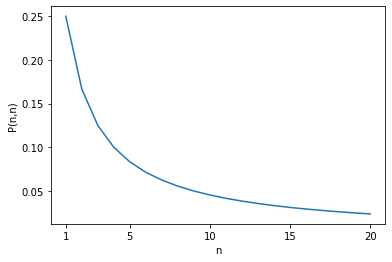

In [38]:
# use dynamic programming to calculate any P
def calc_prob_by_dp_all(n: int) -> List[float]:
    # p[x] = P(Last is black | (x, y)) where y changes during iteration
    p: List[float] = [0.0] * (n + 1)
    # last_p[x] = P(Last is black | (x, y - 1))
    last_p: List[float] = [0.0] * (n + 1)
    # p_all[n - 1] = P(Last is black | (n, n))
    p_all: List[float] = [0.0] * n
    
    for y in range(1, n + 1):
        p[0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[x] = prob_white * p[x - 1] + (1.0 - prob_white) * last_p[x]
        p_all[y - 1] = p[y]
        p, last_p = last_p, p
    
    return p_all

from matplotlib import pyplot as plt

N = 20
ps = calc_prob_by_dp_all(N)
ns = list(range(1, N + 1))
plt.plot(ns, ps)
plt.xlabel('n')
plt.xticks([1, 5, 10, 15, 20])
plt.ylabel('P(n,n)')
plt.show()

# Result

The result seems good.

We notice that
$$
\begin{aligned}
P(1) &= \frac 1 4 &\qquad
P(2) &\approx \frac 1 6\\
P(3) &\approx \frac 1 8 &\qquad
P(4) &\approx \frac 1 {10}\\
P(5) &\approx \frac 1 {12} &\qquad
P(10) &\approx \frac 1 {22}\\
P(100) &\approx \frac 1 {202} &\qquad&
\end{aligned}
$$

Emmm... Maybe
$$
P(n, n) = \frac{1}{2n+2}
$$

To prove that, we must have an idea on what's $P(x, y)$ for any $x$ and $y$. Well, let's plot it.


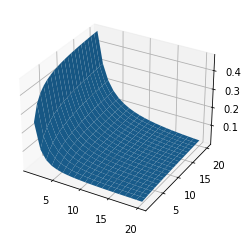

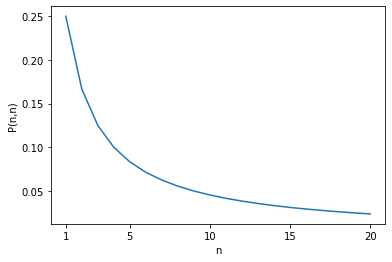

In [39]:

# use dynamic programming to calculate any P
def calc_prob_by_dp_all_xy(n: int) -> List[List[float]]:
    # p[y][x] = P(Last is black | (x, y)) where y changes during iteration
    p: List[List[float]] = [[0.0] * (n + 1) for _ in range(n + 1)]
    
    for y in range(1, n + 1):
        p[y][0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[y][x] = prob_white * p[y][x - 1] + (1.0 - prob_white) * p[y - 1][x]
    
    return p

import numpy as np

N = 20
p = calc_prob_by_dp_all_xy(N)
x, y = np.meshgrid(np.arange(1, N + 1), np.arange(1, N + 1))
axes = plt.figure().gca(projection='3d')
axes.plot_surface(x, y, np.array([p[y + 1][1:] for y in range(N)]))
plt.show()
plt.figure()
ps = [p[n][n] for n in ns]
plt.plot(ns, ps)
plt.xlabel('n')
plt.xticks([1, 5, 10, 15, 20])
plt.ylabel('P(n,n)')
plt.show()

In [40]:
import pandas as pd
pd.DataFrame(np.array(p)[:-1,:-1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.250000,0.111111,0.062500,0.040000,0.027778,0.020408,0.015625,0.012346,0.010000,0.008264,0.006944,0.005917,0.005102,0.004444,0.003906,0.003460,0.003086,0.002770,0.002500
2,1.0,0.333333,0.166667,0.100000,0.066667,0.047619,0.035714,0.027778,0.022222,0.018182,0.015152,0.012821,0.010989,0.009524,0.008333,0.007353,0.006536,0.005848,0.005263,0.004762
3,1.0,0.375000,0.200000,0.125000,0.085714,0.062500,0.047619,0.037500,0.030303,0.025000,0.020979,0.017857,0.015385,0.013393,0.011765,0.010417,0.009288,0.008333,0.007519,0.006818
4,1.0,0.400000,0.222222,0.142857,0.100000,0.074074,0.057143,0.045455,0.037037,0.030769,0.025974,0.022222,0.019231,0.016807,0.014815,0.013158,0.011765,0.010582,0.009569,0.008696
5,1.0,0.416667,0.238095,0.156250,0.111111,0.083333,0.064935,0.052083,0.042735,0.035714,0.030303,0.026042,0.022624,0.019841,0.017544,0.015625,0.014006,0.012626,0.011442,0.010417
6,1.0,0.428571,0.250000,0.166667,0.120000,0.090909,0.071429,0.057692,0.047619,0.040000,0.034091,0.029412,0.025641,0.022556,0.020000,0.017857,0.016043,0.014493,0.013158,0.012000
7,1.0,0.437500,0.259259,0.175000,0.127273,0.097222,0.076923,0.062500,0.051852,0.043750,0.037433,0.032407,0.028340,0.025000,0.022222,0.019886,0.017903,0.016204,0.014737,0.013462
8,1.0,0.444444,0.266667,0.181818,0.133333,0.102564,0.081633,0.066667,0.055556,0.047059,0.040404,0.035088,0.030769,0.027211,0.024242,0.021739,0.019608,0.017778,0.016194,0.014815
9,1.0,0.450000,0.272727,0.187500,0.138462,0.107143,0.085714,0.070312,0.058824,0.050000,0.043062,0.037500,0.032967,0.029221,0.026087,0.023438,0.021176,0.019231,0.017544,0.016071


# Result Again

Emmm... It seems:
$$
\begin{aligned}
P(x,1)&=\frac{1}{(x+1)^2}\\
P(x,2)&=\frac{2}{(x+1)(x+2)}\\
P(x,3)&=\frac{3}{(x+1)(x+3)}\\
...&
\end{aligned}
$$
Maybe
$$
P(x,y)=\frac{y}{(x+1)(x+y)}
$$

Well, at least it fits our previous guess $P(n,n)=\frac{1}{2n+2}$. Let's prove it.

First, about boundary conditions:
$$
\begin{aligned}
P(x, 0) &= \frac{0}{x(x+1)} = 0\\
P(0, y) &= \frac{y}{y} = 1
\end{aligned}
$$

It seems good. And about recursion:
$$
\begin{aligned}
P(x, y) &= \frac{x^2}{(x + y)^2} \cdot P(x - 1, y) + \frac{2 x y + y^2}{(x + y)^2} \cdot P(x, y - 1) \\
&= \frac{x^2}{(x + y)^2} \cdot \frac{y}{x(x+y-1)} + \frac{2 x y + y^2}{(x + y)^2} \cdot \frac{y-1}{(x+1)(x+y-1)} \\
&= \frac{xy(x+1)}{(x + y)^2(x+1)(x+y-1)} + \frac{(2 x y + y^2)(y-1)}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{x^2y+xy+2xy^2+y^3-2xy-y^2}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y(x^2+x+2xy+y^2-2x-y)}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y((x+y)^2-(x+y))}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y((x+y)(x+y-1))}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y}{(x+1)(x+y)}
\end{aligned}
$$


# OHHHHHHH

Nice! So the answer should be:
$$
P(x,y)=\frac{y}{(x+1)(x+y)}
$$